Import Required Libraries

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from imblearn.over_sampling import SMOTE
import joblib


Load and Inspect the Dataset

In [2]:
# Load dataset
data = pd.read_csv('creditcard.csv')


In [3]:
# Display first few rows
print(data.head())
print(data.info())
print(data.describe())

   Time        V1        V2        V3        V4        V5        V6        V7  \
0   0.0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1   0.0  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
2   1.0 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   
3   1.0 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203  0.237609   
4   2.0 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921  0.592941   

         V8        V9  ...       V21       V22       V23       V24       V25  \
0  0.098698  0.363787  ... -0.018307  0.277838 -0.110474  0.066928  0.128539   
1  0.085102 -0.255425  ... -0.225775 -0.638672  0.101288 -0.339846  0.167170   
2  0.247676 -1.514654  ...  0.247998  0.771679  0.909412 -0.689281 -0.327642   
3  0.377436 -1.387024  ... -0.108300  0.005274 -0.190321 -1.175575  0.647376   
4 -0.270533  0.817739  ... -0.009431  0.798278 -0.137458  0.141267 -0.206010   

        V26       V27       V28 

 Exploratory Data Analysis (EDA)

In [5]:
# Class distribution
print(data['class'].value_counts())


class
0    284315
1       492
Name: count, dtype: int64


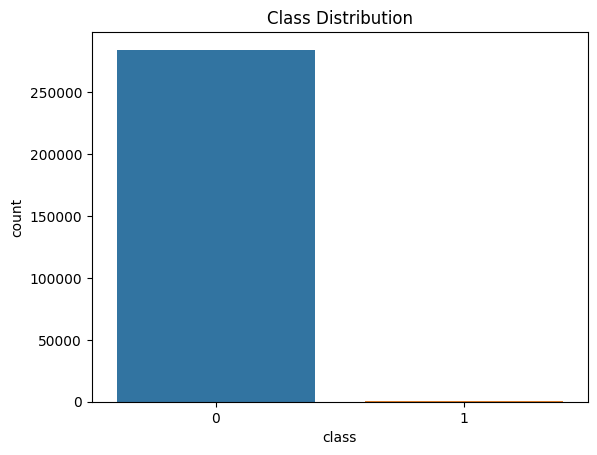

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.countplot(x='class', data=data)
plt.title('Class Distribution')
plt.show()


In [19]:
data1 = data.groupby('class').apply(lambda x: x.sample(n=4000, replace=True, random_state=1)).reset_index(drop=True)
data1['class'].value_counts()

class
0    4000
1    4000
Name: count, dtype: int64

Separate Features and Target

In [20]:
X = data1.drop('class', axis=1)
y = data1['class']


Since the data is highly imbalanced, we will use SMOTE (Synthetic Minority Over-sampling Technique) to balance it.

In [21]:
smote = SMOTE(random_state=42)
X_res, y_res = smote.fit_resample(X, y)


In [22]:
X_res.shape
y_res.value_counts()

class
0    4000
1    4000
Name: count, dtype: int64

Feature Scaling

In [23]:
scaler = StandardScaler()
X_res_scaled = scaler.fit_transform(X_res)
X_train, X_test, y_train, y_test = train_test_split(X_res_scaled, y_res, test_size=0.3, random_state=42)


Model Training and Hyperparameter Tuning

Logistic Regression

In [24]:
# Logistic Regression
log_reg = LogisticRegression(random_state=42)
log_reg_params = {
    'C': [0.01, 0.1, 1, 10, 100],
    'penalty': ['l1', 'l2', 'elasticnet', 'none'],
    'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
}

In [25]:
log_reg_grid = GridSearchCV(log_reg, log_reg_params, cv=5, n_jobs=-1, verbose=1)
log_reg_grid.fit(X_train, y_train)

print(f'Best Logistic Regression Parameters: {log_reg_grid.best_params_}')

Fitting 5 folds for each of 100 candidates, totalling 500 fits


C:\Users\user\anaconda\Lib\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
225 fits failed out of a total of 500.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
25 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\user\anaconda\Lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda\Lib\site-packages\sklearn\linear_model\_logistic.py", line 1162, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\user\anaconda\Lib\site-packages\sklearn\linear_model\_logistic

Best Logistic Regression Parameters: {'C': 100, 'penalty': 'l2', 'solver': 'liblinear'}


K-Nearest Neighbors

In [26]:
# K-Nearest Neighbors
knn = KNeighborsClassifier()
knn_params = {
    'n_neighbors': [3, 5, 7, 9, 11],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan', 'minkowski']
}

In [27]:
knn_grid = GridSearchCV(knn, knn_params, cv=5, n_jobs=-1, verbose=1)
knn_grid.fit(X_train, y_train)

print(f'Best KNN Parameters: {knn_grid.best_params_}')

Fitting 5 folds for each of 30 candidates, totalling 150 fits
Best KNN Parameters: {'metric': 'manhattan', 'n_neighbors': 3, 'weights': 'distance'}


Decision Tree

In [28]:
# Decision Tree
dt = DecisionTreeClassifier(random_state=42)
dt_params = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 10, 20, 30, 40, 50],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

In [29]:
dt_grid = GridSearchCV(dt, dt_params, cv=5, n_jobs=-1, verbose=1)
dt_grid.fit(X_train, y_train)

print(f'Best Decision Tree Parameters: {dt_grid.best_params_}')

Fitting 5 folds for each of 108 candidates, totalling 540 fits
Best Decision Tree Parameters: {'criterion': 'gini', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2}


Model Evaluation

In [31]:
# Evaluate the models
models = {
    'Logistic Regression': log_reg_grid.best_estimator_,
    'K-Nearest Neighbors': knn_grid.best_estimator_,
    'Decision Tree': dt_grid.best_estimator_
}

In [33]:
results = {}
for model_name, model in models.items():
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred)
    
    results[model_name] = {
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1,
        'ROC AUC': roc_auc
    }
    # Save the model
    joblib.dump(model, f'model/{model_name.replace(" ", "_")}.joblib')

In [34]:
# Print results
for model_name, metrics in results.items():
    print(f"{model_name}:\n"
          f"Accuracy: {metrics['Accuracy']}\n"
          f"Precision: {metrics['Precision']}\n"
          f"Recall: {metrics['Recall']}\n"
          f"F1 Score: {metrics['F1 Score']}\n"
          f"ROC AUC: {metrics['ROC AUC']}\n")

Logistic Regression:
Accuracy: 0.94875
Precision: 0.9709762532981531
Recall: 0.9246231155778895
F1 Score: 0.9472329472329473
ROC AUC: 0.9486299657491437

K-Nearest Neighbors:
Accuracy: 0.98875
Precision: 0.980246913580247
Recall: 0.9974874371859297
F1 Score: 0.9887920298879204
ROC AUC: 0.988793469836746

Decision Tree:
Accuracy: 0.9904166666666666
Precision: 0.9834847233691164
Recall: 0.9974874371859297
F1 Score: 0.9904365904365905
ROC AUC: 0.9904518446294491

